In [1]:
import os
import itertools
import time
import random

import numpy as np # linear algebra
from scipy import signal as sc
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score
from math import floor, ceil
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import os
from math import floor, ceil
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from matplotlib import colors
import seaborn as sns
from adabelief_pytorch import AdaBelief
from termcolor import colored


/home/benx13/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomImageDataset(Dataset):
  def __init__(self, labels_file, img_dir, transform=None):
    self.img_labels = scipy.io.loadmat(labels_file)['code_bdh'][0]
    self.img_dir = img_dir
    self.transform = transform
    self.imgs = [img for img in os.listdir(img_dir)]
    self.imgs.sort() 

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    image = Image.open(self.img_dir + '/' + self.imgs[idx])
    label = self.img_labels[idx] -1
    if self.transform:
      image = self.transform(image)
    return np.array(image), label

In [3]:
transform = T.Compose([
   T.Resize((100, 300)),
   T.ToTensor()
]) 
img_dir = 'data_2021/data_2021/png'
labels_file = 'data_2021/data_2021/code_bdh.mat'

In [4]:
dataset = CustomImageDataset(labels_file, img_dir, transform=transform) 
train_set, test_set = torch.utils.data.random_split(dataset, [floor(len(dataset) * 0.85), ceil(len(dataset)*0.15)])
train_loader = DataLoader(train_set, batch_size=110 , shuffle=True)
test_loader = DataLoader(test_set, batch_size=110, shuffle=True)

In [5]:
for i in train_loader:
    print(i[0].shape)
    break

torch.Size([110, 3, 100, 300])


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 22)
model= nn.DataParallel(model)
model.to(device)
adam_belief = AdaBelief(model.parameters(), lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)
#adam = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.CrossEntropyLoss()

/home/benx13/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/benx13/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [122]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

11187798

In [123]:
def train_single_batch(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    i, (signal, labels) = next(enumerate(train_loader))
    signal = signal.to(device)
    labels = labels.to(device)

    for epoch in tqdm(range(epochs)):
        acc = []
        correct = 0
        total = 0

        # Forward pass
        outputs = model(signal)
        loss = criterion(outputs, labels)


        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, outputs = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (labels == outputs).sum() 
        acc.append((correct/total).item())


        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))
        


    return train_loss, train_acc

In [124]:
train_loss, train_acc = train_single_batch(model=model, criterion=criterion, optimizer=adam_belief, epochs=50, train_loader=train_loader, test_loader=test_loader)

100%|██████████| 50/50 [00:05<00:00,  8.89it/s]


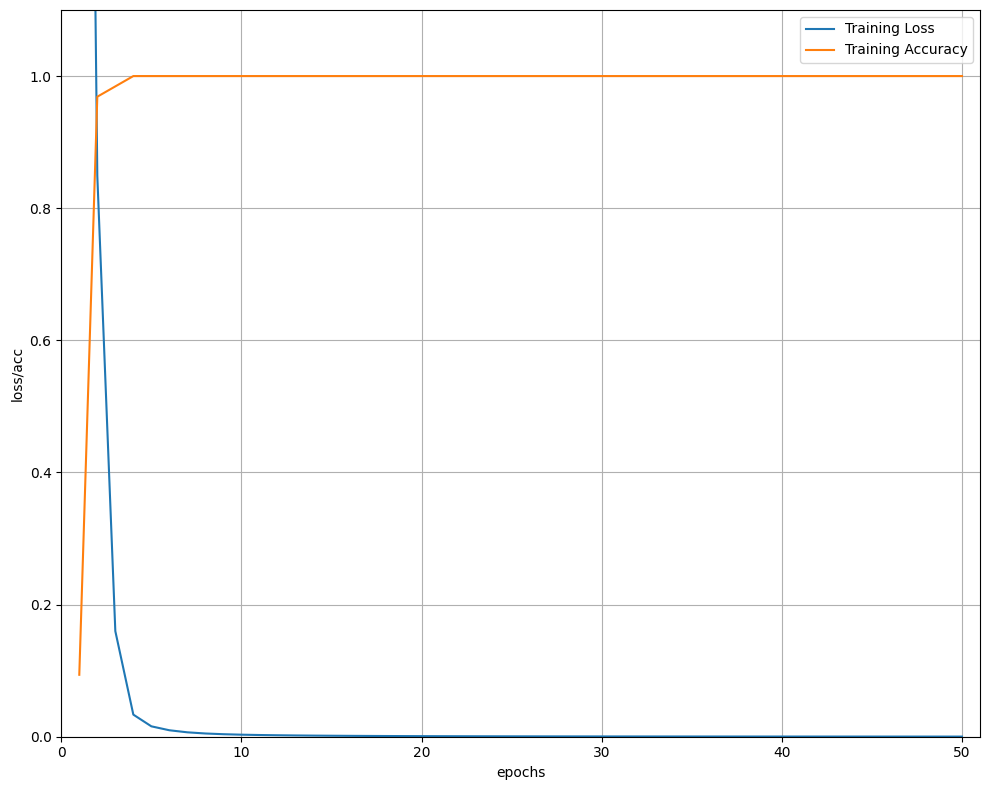

In [125]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Accuracy')

plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [126]:
def train(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    conf_mats = []
    val_loss_min = 1
    bar = tqdm(range(epochs))
    for epoch in bar:
        acc = []
        correct = 0
        total = 0  
        # Training step
        for i, (signal, labels) in enumerate(train_loader):
            signal = signal.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(signal)

            loss = criterion(outputs, labels)


            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, outputs = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (labels == outputs).sum() 
            acc.append((correct/total).item())

        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))

        # Validation step
        correct = 0
        total = 0  
        v_loss = []
        v_acc = []
        confusion_matrix = torch.zeros(22, 22)
        for signal, labels in test_loader:
            signal = signal.to(device)
            labels = labels.to(device)
            predictions = model(signal)
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0) 
            correct += (labels == predicted).sum() 
            loss = criterion(predictions, labels)
            v_loss.append(loss.item())
            v_acc.append((correct/total).item())

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            conf_mats.append(confusion_matrix)

        bar.set_postfix({'\033[91m Val Loss:': np.mean(v_loss), '\033[92m Val Acc:': float(correct/total),"\033[0m \n":""})
        #print('\033[91m Val Loss: '+str(np.mean(v_loss)), '\033[92m  Val Acc: '+ str(correct/total), "")

        val_acc.append((correct/total).item())
        val_loss.append(np.mean(v_loss))

        
        train_history = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'confusion_matrix':conf_mats
        }


    return train_history, model

In [127]:
t_h, model = train(model=model, criterion=criterion, optimizer=adam_belief, epochs=50, train_loader=train_loader, test_loader=test_loader)

  0%|          | 0/50 [00:20<?, ?it/s,  Val Loss:=0.0439,  Val Acc:=0.992,  
  2%|▏         | 1/50 [00:20<16:37, 20.36s/it,  Val Loss:=0.0439,  Val Acc:=0.992,  
  2%|▏         | 1/50 [00:43<16:37, 20.36s/it,  Val Loss:=0.0218,  Val Acc:=0.996,  
  4%|▍         | 2/50 [00:43<17:31, 21.91s/it,  Val Loss:=0.0218,  Val Acc:=0.996,  
  4%|▍         | 2/50 [01:04<17:31, 21.91s/it,  Val Loss:=0.0251,  Val Acc:=0.993,  
  6%|▌         | 3/50 [01:04<16:52, 21.55s/it,  Val Loss:=0.0251,  Val Acc:=0.993,  
  6%|▌         | 3/50 [01:29<16:52, 21.55s/it,  Val Loss:=0.0218,  Val Acc:=0.994,  
  8%|▊         | 4/50 [01:29<17:29, 22.81s/it,  Val Loss:=0.0218,  Val Acc:=0.994,  
  8%|▊         | 4/50 [01:54<17:29, 22.81s/it,  Val Loss:=0.0192,  Val Acc:=0.994,  
 10%|█         | 5/50 [01:54<17:41, 23.60s/it,  Val Loss:=0.0192,  Val Acc:=0.994,  
 10%|█         | 5/50 [02:14<17:41, 23.60s/it,  Val Loss:=0.0175,  Val Acc:=0.997,  
 12%|█▏        | 6/50 [02:14<16:27, 22.44s/it,  Val Loss:=0.0175,  Val Ac

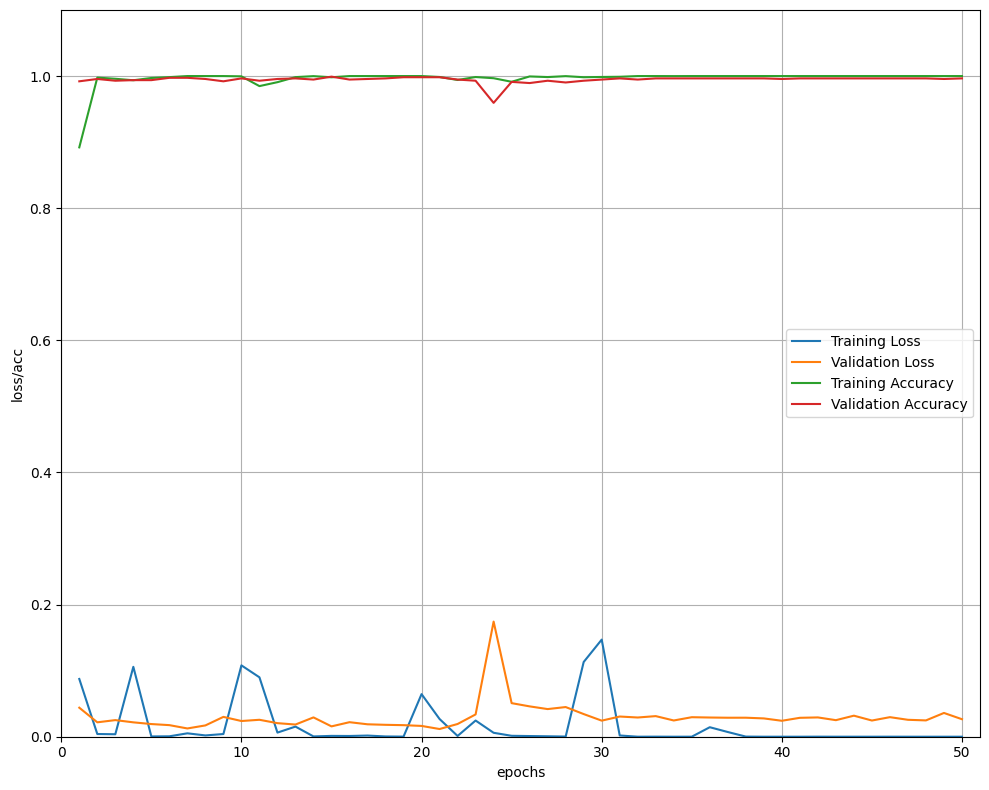

In [128]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(t_h['train_loss'])+1),t_h['train_loss'], label='Training Loss')
plt.plot(range(1,len(t_h['val_loss'])+1),t_h['val_loss'],label='Validation Loss')
plt.plot(range(1,len(t_h['train_acc'])+1),t_h['train_acc'], label='Training Accuracy')
plt.plot(range(1,len(t_h['val_acc'])+1),t_h['val_acc'],label='Validation Accuracy')


plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(t_h['train_loss'])+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [129]:
flatten = lambda t: [item for sublist in t for item in sublist]

y_pred_list = []
y_test_list = []
with torch.no_grad():
    model.eval()
    for X_batch, y_tag in tqdm(test_loader):
        #print(y_tag.tolist())
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #print(F.softmax(y_test_pred, dim=1))
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_test_list.append(y_tag)
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = flatten(y_pred_list)
y_test_list = flatten(y_test_list)

100%|██████████| 18/18 [00:02<00:00,  7.82it/s]


<AxesSubplot: >

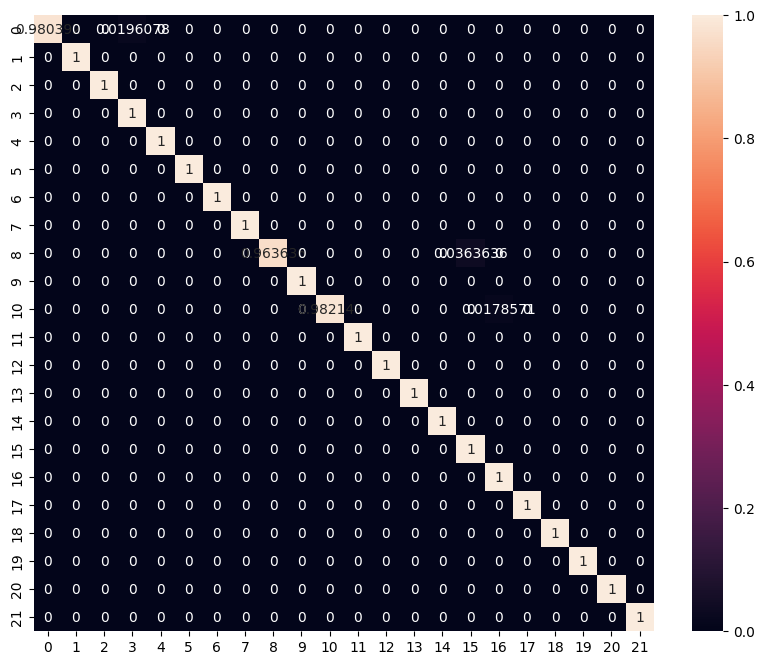

In [130]:
cm = confusion_matrix(np.array(y_test_list),np.array(y_pred_list))
cm = cm/cm.sum(axis=1)[:,None]
confusion_matrix_df = pd.DataFrame(cm)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

In [131]:
print(classification_report(y_test_list, y_pred_list, digits=4))


              precision    recall  f1-score   support

           0     1.0000    0.9804    0.9901        51
           1     1.0000    1.0000    1.0000        55
           2     1.0000    1.0000    1.0000        64
           3     0.9714    1.0000    0.9855        34
           4     1.0000    1.0000    1.0000        49
           5     1.0000    1.0000    1.0000        37
           6     1.0000    1.0000    1.0000        62
           7     1.0000    1.0000    1.0000        51
           8     1.0000    0.9636    0.9815        55
           9     1.0000    1.0000    1.0000        51
          10     1.0000    0.9821    0.9910        56
          11     1.0000    1.0000    1.0000        48
          12     1.0000    1.0000    1.0000        46
          13     1.0000    1.0000    1.0000        56
          14     1.0000    1.0000    1.0000        49
          15     0.9565    1.0000    0.9778        44
          16     0.9821    1.0000    0.9910        55
          17     1.0000    

In [7]:
from efficientnet_pytorch import EfficientNet
torchvision.models.efficientnet_v2_l

<function torchvision.models.efficientnet.efficientnet_v2_l(*, weights: Optional[torchvision.models.efficientnet.EfficientNet_V2_L_Weights] = None, progress: bool = True, **kwargs: Any) -> torchvision.models.efficientnet.EfficientNet>

In [7]:
from torch.nn.parallel import DistributedDataParallel as DDP


In [7]:
model = model = torchvision.models.efficientnet_b0(pretrained=True)
model.fc = nn.Linear(512, 22)
model= nn.DataParallel(model)
model.to(device)
adam_belief = AdaBelief(model.parameters(), lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)
#adam = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = nn.CrossEntropyLoss()

/home/benx13/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/benx13/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

5299834

In [9]:
def train_single_batch(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    i, (signal, labels) = next(enumerate(train_loader))
    signal = signal.to(device)
    labels = labels.to(device)

    for epoch in tqdm(range(epochs)):
        acc = []
        correct = 0
        total = 0

        # Forward pass
        outputs = model(signal)
        loss = criterion(outputs, labels)


        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, outputs = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (labels == outputs).sum() 
        acc.append((correct/total).item())


        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))
        


    return train_loss, train_acc

In [11]:
train_loss, train_acc = train_single_batch(model=model, criterion=criterion, optimizer=adam_belief, epochs=50, train_loader=train_loader, test_loader=test_loader)

100%|██████████| 50/50 [00:15<00:00,  3.27it/s]


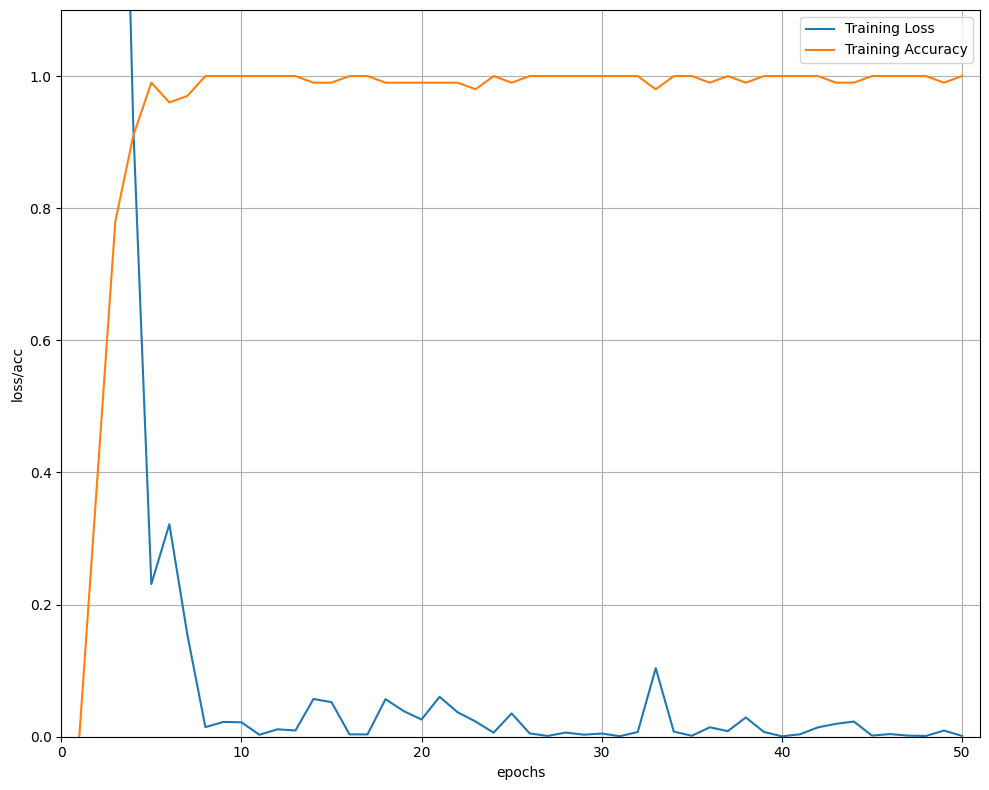

In [12]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Accuracy')

plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
def train(model=None, criterion=None, optimizer=None, train_loader=None, test_loader=None,epochs=64):
    # Train the model
    total_step = len(train_loader)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    conf_mats = []
    val_loss_min = 1
    bar = tqdm(range(epochs))
    for epoch in bar:
        acc = []
        correct = 0
        total = 0  
        # Training step
        for i, (signal, labels) in enumerate(train_loader):
            signal = signal.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(signal)

            loss = criterion(outputs, labels)


            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, outputs = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (labels == outputs).sum() 
            acc.append((correct/total).item())

        #print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}".format(epoch+1, epochs, i+1, total_step, loss.item(), np.mean(acc)))
        train_loss.append(loss.item())
        train_acc.append(np.mean(acc))

        # Validation step
        correct = 0
        total = 0  
        v_loss = []
        v_acc = []
        confusion_matrix = torch.zeros(22, 22)
        for signal, labels in test_loader:
            signal = signal.to(device)
            labels = labels.to(device)
            predictions = model(signal)
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0) 
            correct += (labels == predicted).sum() 
            loss = criterion(predictions, labels)
            v_loss.append(loss.item())
            v_acc.append((correct/total).item())

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            conf_mats.append(confusion_matrix)

        bar.set_postfix({'\033[91m Val Loss:': np.mean(v_loss), '\033[92m Val Acc:': float(correct/total),"\033[0m \n":""})
        #print('\033[91m Val Loss: '+str(np.mean(v_loss)), '\033[92m  Val Acc: '+ str(correct/total), "")

        val_acc.append((correct/total).item())
        val_loss.append(np.mean(v_loss))

        
        train_history = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'confusion_matrix':conf_mats
        }


    return train_history, model

In [11]:
t_h, model = train(model=model, criterion=criterion, optimizer=adam_belief, epochs=50, train_loader=train_loader, test_loader=test_loader)

  0%|          | 0/50 [00:27<?, ?it/s,  Val Loss:=0.0524,  Val Acc:=0.986,  
  2%|▏         | 1/50 [00:27<22:48, 27.93s/it,  Val Loss:=0.0524,  Val Acc:=0.986,  
  2%|▏         | 1/50 [00:52<22:48, 27.93s/it,  Val Loss:=0.0367,  Val Acc:=0.989,  
  4%|▍         | 2/50 [00:52<20:52, 26.10s/it,  Val Loss:=0.0367,  Val Acc:=0.989,  
  4%|▍         | 2/50 [01:17<20:52, 26.10s/it,  Val Loss:=0.0281,  Val Acc:=0.993,  
  6%|▌         | 3/50 [01:17<20:05, 25.65s/it,  Val Loss:=0.0281,  Val Acc:=0.993,  
  6%|▌         | 3/50 [01:43<20:05, 25.65s/it,  Val Loss:=0.0244,  Val Acc:=0.994,  
  8%|▊         | 4/50 [01:43<19:31, 25.46s/it,  Val Loss:=0.0244,  Val Acc:=0.994,  
  8%|▊         | 4/50 [02:08<19:31, 25.46s/it,  Val Loss:=0.0466,  Val Acc:=0.988,  
 10%|█         | 5/50 [02:08<19:01, 25.36s/it,  Val Loss:=0.0466,  Val Acc:=0.988,  
 10%|█         | 5/50 [02:33<19:01, 25.36s/it,  Val Loss:=0.0308,  Val Acc:=0.993,  
 12%|█▏        | 6/50 [02:33<18:35, 25.34s/it,  Val Loss:=0.0308,  Val Ac

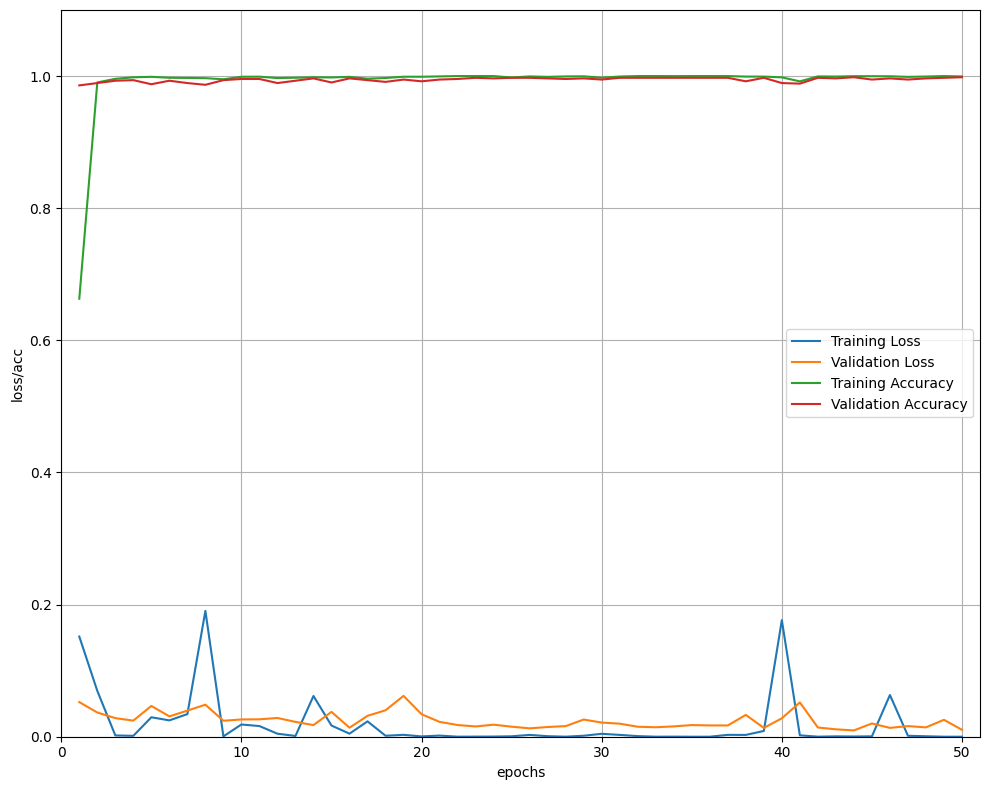

In [12]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(t_h['train_loss'])+1),t_h['train_loss'], label='Training Loss')
plt.plot(range(1,len(t_h['val_loss'])+1),t_h['val_loss'],label='Validation Loss')
plt.plot(range(1,len(t_h['train_acc'])+1),t_h['train_acc'], label='Training Accuracy')
plt.plot(range(1,len(t_h['val_acc'])+1),t_h['val_acc'],label='Validation Accuracy')


plt.xlabel('epochs')
plt.ylabel('loss/acc')
plt.ylim(0, 1.1) # consistent scale
plt.xlim(0, len(t_h['train_loss'])+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
flatten = lambda t: [item for sublist in t for item in sublist]

y_pred_list = []
y_test_list = []
with torch.no_grad():
    model.eval()
    for X_batch, y_tag in tqdm(test_loader):
        #print(y_tag.tolist())
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #print(F.softmax(y_test_pred, dim=1))
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_test_list.append(y_tag)
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = flatten(y_pred_list)
y_test_list = flatten(y_test_list)

100%|██████████| 11/11 [00:02<00:00,  4.04it/s]


<AxesSubplot: >

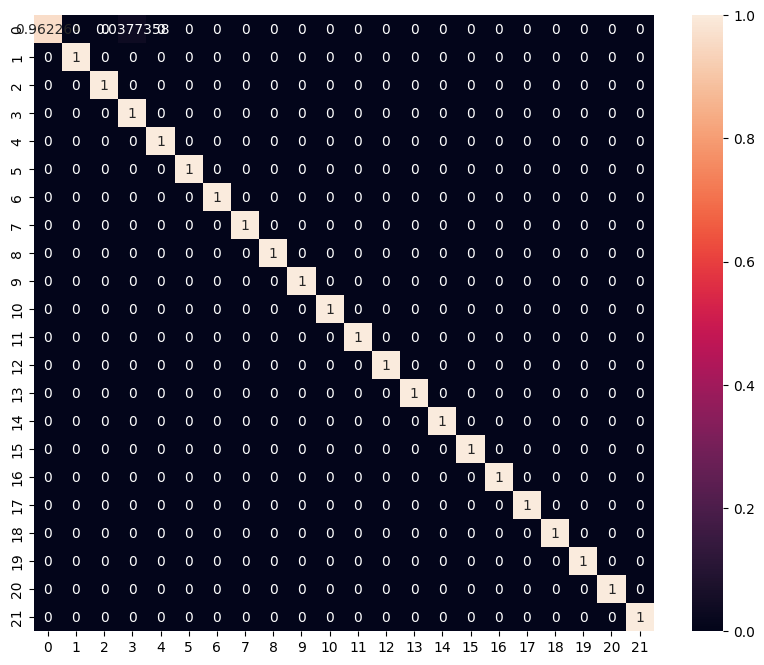

In [14]:
cm = confusion_matrix(np.array(y_test_list),np.array(y_pred_list))
cm = cm/cm.sum(axis=1)[:,None]
confusion_matrix_df = pd.DataFrame(cm)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

In [15]:
print(classification_report(y_test_list, y_pred_list, digits=4))


              precision    recall  f1-score   support

           0     1.0000    0.9623    0.9808        53
           1     1.0000    1.0000    1.0000        46
           2     1.0000    1.0000    1.0000        59
           3     0.9535    1.0000    0.9762        41
           4     1.0000    1.0000    1.0000        52
           5     1.0000    1.0000    1.0000        52
           6     1.0000    1.0000    1.0000        44
           7     1.0000    1.0000    1.0000        52
           8     1.0000    1.0000    1.0000        57
           9     1.0000    1.0000    1.0000        41
          10     1.0000    1.0000    1.0000        49
          11     1.0000    1.0000    1.0000        56
          12     1.0000    1.0000    1.0000        59
          13     1.0000    1.0000    1.0000        48
          14     1.0000    1.0000    1.0000        52
          15     1.0000    1.0000    1.0000        48
          16     1.0000    1.0000    1.0000        56
          17     1.0000    